# Unit 4: Applied Machine Learning 2
## Task 8: Convolutional neural network
###### Candelaria Retamal
###### **29.06.2022**


You tested above different models with the set of high-level features extracted from a pretrained neural network. However, can you get similar results by creating a ConvNet from scratch and using the pixel values from the original images to train the model?

#### 8.1. What accuracy can you achieve?

The same process than before, but instead of using the high features previously computed with MobileNET v2, I do it from scratch by tanking the original RGB pixels.

In [1]:
%matplotlib inline
from IPython.display import display
import PIL.Image as Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# Create image generator
train_generator = ImageDataGenerator(
    rescale=1 / 255)
validation_generator = ImageDataGenerator(
    rescale=1 / 255)
test_generator = ImageDataGenerator(rescale=1. / 255)



# Train, validation and test sets
trainset = train_generator.flow_from_directory(
    os.path.join("images", "train"),
    target_size=(224, 224),
    shuffle=True,
    batch_size = 5,
    classes=["bike","car","motorcycle","other","truck","van"]
)

validset = validation_generator.flow_from_directory(
    os.path.join("images", "valid"),
    target_size=(224, 224),
    shuffle=True
)
testset = test_generator.flow_from_directory(
    os.path.join("images", "test"), target_size=(224, 224), shuffle=True
)


Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [2]:
set(trainset.filenames).intersection(set(validset.filenames))

set()

I create a model with sequential, adding different layers of convolution, pools, etc.

In [3]:
# Convolutional Network
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, activation="relu",
                              input_shape=(224, 224,3)))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu"))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=trainset.num_classes, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 128)     9728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0         
_________________________________________________________________
dense (Dense)                (None, 6)                 259590    
Total params: 343,110
Trainable params: 343,110
Non-trainable params: 0
__________________________________________________

Compile and training...

In [4]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=["acc"])

In [5]:
# End training when accuracy stops improving (optional)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)

In [6]:
# Train model
history = model.fit(
    trainset, validation_data=validset, epochs=100, callbacks=[early_stopping]
)

Epoch 1/100
56/56 [==============================] - 6s 107ms/step - loss: 1.7836 - acc: 0.2286 - val_loss: 1.6830 - val_acc: 0.4388
Epoch 2/100
56/56 [==============================] - 6s 102ms/step - loss: 1.5063 - acc: 0.4357 - val_loss: 1.5976 - val_acc: 0.3813
Epoch 3/100
56/56 [==============================] - 6s 101ms/step - loss: 0.8359 - acc: 0.7143 - val_loss: 1.5501 - val_acc: 0.4604
Epoch 4/100
56/56 [==============================] - 6s 101ms/step - loss: 0.2774 - acc: 0.9107 - val_loss: 2.0240 - val_acc: 0.4604
Epoch 5/100
56/56 [==============================] - 6s 102ms/step - loss: 0.0603 - acc: 0.9786 - val_loss: 2.2562 - val_acc: 0.4317
Epoch 6/100
56/56 [==============================] - 6s 103ms/step - loss: 0.0109 - acc: 1.0000 - val_loss: 2.6385 - val_acc: 0.4820
Epoch 7/100
56/56 [==============================] - 6s 102ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 3.1039 - val_acc: 0.4101
Epoch 8/100
56/56 [==============================] - 6s 101ms/step - 

I plot the accuracy and loss function evolution with epochs.

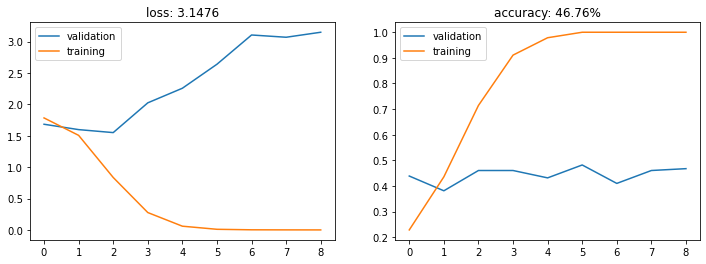

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title("loss: {:.4f}".format(history.history["val_loss"][-1]))
ax1.plot(history.history["val_loss"], label="validation")
ax1.plot(history.history["loss"], label="training")
ax1.legend()

# plot accuracy values
ax2.set_title("accuracy: {:.2f}%".format(history.history["val_acc"][-1] * 100))
ax2.plot(history.history["val_acc"], label="validation")
ax2.plot(history.history["acc"], label="training")
ax2.legend()

plt.show()

Model prediction for the testset.

In [8]:
test_preds = model.predict(testset)
print("Predictions:", test_preds.shape)

Predictions: (50, 6)


Confusion matrix and accuracy assessment. 

In [9]:
# Compute confusion matrix
matrix = confusion_matrix(
    y_true=testset.classes,            # array with true labels
    y_pred=test_preds.argmax(axis=1),  # array with predicted labels
)

# Format as a DataFrame
class_names = list(testset.class_indices.keys())
matrix_df = pd.DataFrame(data=matrix, columns=class_names, index=class_names)
matrix_df.columns.name = "Predictions"
matrix_df.index.name = "True class"
matrix_df

Predictions,bike,car,motorcycle,other,truck,van
True class,,,,,,
bike,5,2,1,1,2,1
car,1,3,4,0,2,1
motorcycle,1,3,2,0,2,1
other,3,0,1,0,2,0
truck,2,1,1,0,2,1
van,2,2,0,0,1,0


In [10]:
test_loss, test_acurracy = model.evaluate(testset)
print("Test loss: {:.2f}, accuracy: {:.2f}%".format(test_loss, test_acurracy * 100))
# Output varies with an accuracy score around 52% and a loss around 1.4

2/2 [==============================] - 0s 63ms/step - loss: 2.9702 - acc: 0.4600
Test loss: 2.97, accuracy: 46.00%


The accuracy for this configuration of the model is 46%.

#### 8.2. Can you get good results? - If not, why?

The best result I managed to find was 46% of accuracy by changing the number of filters for the convolution layers. I think this low performance must be mainly caused by the small ammount of data we count for training. Despite we reach an accuracy with the training set close to 100%, the validation is somehow stable around 45% after a few epochs.
If we compare the performance with a simple 2-layer NN that process the output coming from the MobileNET v2, it is much lower. This occurs because this pre-processing model is optimized to capture important features by computing specific and more complex filters, compared to what we have here in the convolutional layers.